In [1]:
#Type 1 MEL SPECTROGRAM

Training model for spectrogram type: mel
Epoch 1/50
13/13 [==============================] - 20s 914ms/step - loss: 0.7270 - accuracy: 0.5153 - val_loss: 0.7067 - val_accuracy: 0.5102
Epoch 2/50
13/13 [==============================] - 8s 620ms/step - loss: 0.7005 - accuracy: 0.5153 - val_loss: 0.6935 - val_accuracy: 0.5102
Epoch 3/50
13/13 [==============================] - 8s 579ms/step - loss: 0.6942 - accuracy: 0.5153 - val_loss: 0.6913 - val_accuracy: 0.5102
Epoch 4/50
13/13 [==============================] - 8s 614ms/step - loss: 0.6937 - accuracy: 0.5153 - val_loss: 0.6912 - val_accuracy: 0.5102
Epoch 5/50
13/13 [==============================] - 8s 603ms/step - loss: 0.6938 - accuracy: 0.5153 - val_loss: 0.6915 - val_accuracy: 0.5102
Epoch 6/50
13/13 [==============================] - 8s 623ms/step - loss: 0.6947 - accuracy: 0.5153 - val_loss: 0.6913 - val_accuracy: 0.5102
Epoch 7/50
13/13 [==============================] - 8s 597ms/step - loss: 0.6936 - accuracy: 0.5000 - val_

C:\Users\NUTAN SINGH\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


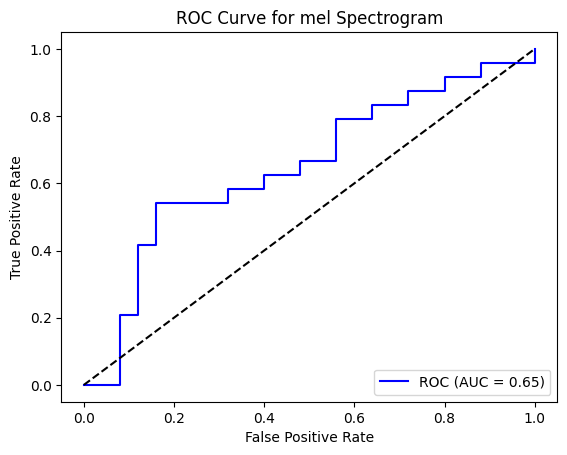


Performance Metrics for Spectrogram mel:
Accuracy: 51.02%
F1 Score: 0.34
Precision: 0.26
Recall: 0.51
Specificity: 1.00
Kappa: 0.00
ROC AUC: 0.65
Training Time: 81.37 seconds
Testing Time: 13.32 seconds


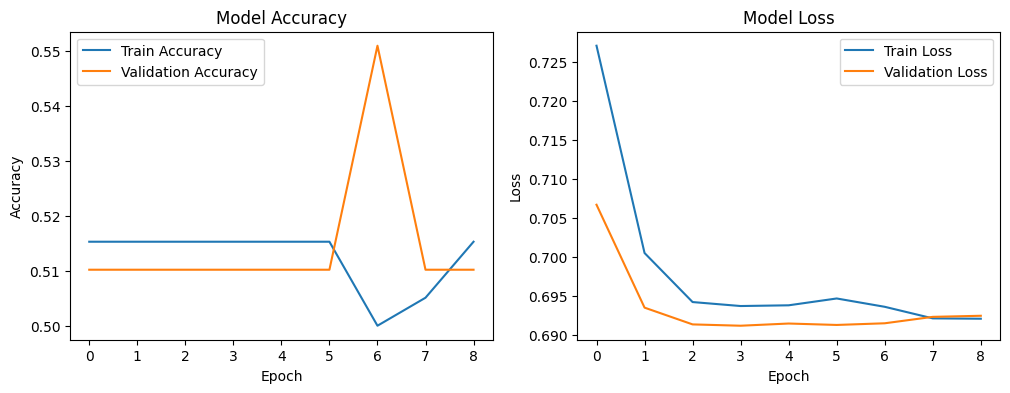

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    
    # Shuffle and split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.2, stratify=labels, random_state=42)
    
    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=50, 
                        batch_size=16, 
                        verbose=1, 
                        callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display metrics
    print(f"\nPerformance Metrics for Spectrogram {spectrogram}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: mel
Epoch 1/50
13/13 [==============================] - 20s 1s/step - loss: 0.7367 - accuracy: 0.4235 - val_loss: 0.7103 - val_accuracy: 0.4694
Epoch 2/50
13/13 [==============================] - 19s 1s/step - loss: 0.7015 - accuracy: 0.5561 - val_loss: 0.6948 - val_accuracy: 0.4694
Epoch 3/50
13/13 [==============================] - 19s 1s/step - loss: 0.6929 - accuracy: 0.5357 - val_loss: 0.6925 - val_accuracy: 0.5510
Epoch 4/50
13/13 [==============================] - 18s 1s/step - loss: 0.6931 - accuracy: 0.5306 - val_loss: 0.6923 - val_accuracy: 0.5510
Epoch 5/50
13/13 [==============================] - 18s 1s/step - loss: 0.6885 - accuracy: 0.5918 - val_loss: 0.6920 - val_accuracy: 0.5306
Epoch 6/50
13/13 [==============================] - 18s 1s/step - loss: 0.6872 - accuracy: 0.5561 - val_loss: 0.6929 - val_accuracy: 0.4898
Epoch 7/50
13/13 [==============================] - 18s 1s/step - loss: 0.6858 - accuracy: 0.5255 - val_loss: 0.6929 - 

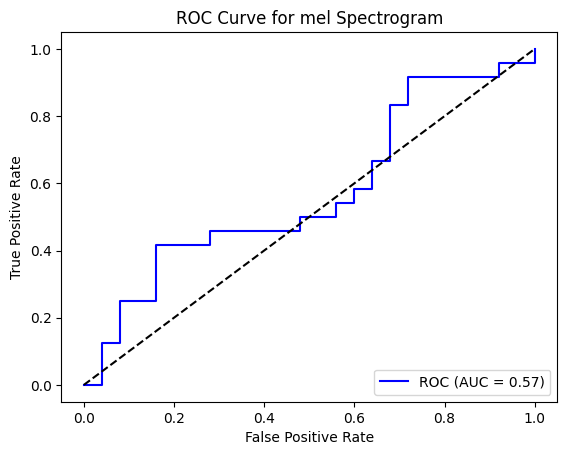

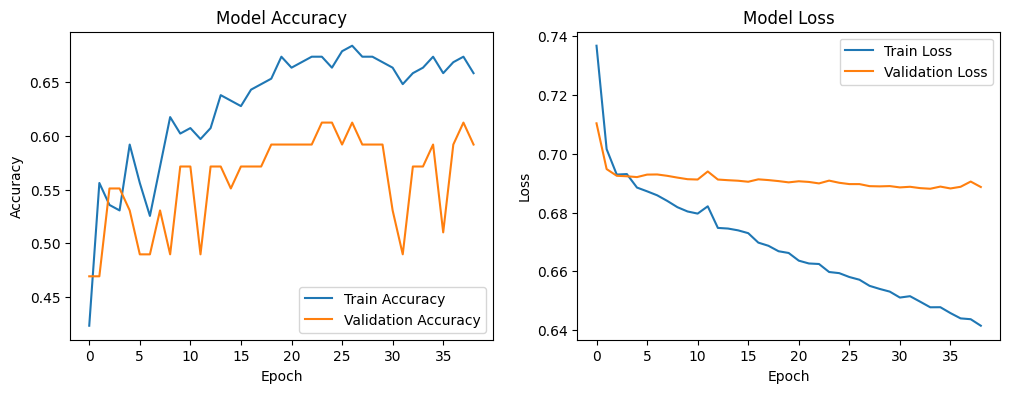

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary (similar to your fold_metrics structure)
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve (single curve instead of mean±std from k-fold)
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: mel
Epoch 1/50
13/13 [==============================] - 9s 280ms/step - loss: 0.6795 - accuracy: 0.5816 - val_loss: 0.6821 - val_accuracy: 0.6327
Epoch 2/50
13/13 [==============================] - 2s 158ms/step - loss: 0.6415 - accuracy: 0.7092 - val_loss: 0.6752 - val_accuracy: 0.5918
Epoch 3/50
13/13 [==============================] - 2s 162ms/step - loss: 0.6204 - accuracy: 0.7551 - val_loss: 0.6702 - val_accuracy: 0.5918
Epoch 4/50
13/13 [==============================] - 2s 176ms/step - loss: 0.6002 - accuracy: 0.7704 - val_loss: 0.6635 - val_accuracy: 0.6327
Epoch 5/50
13/13 [==============================] - 2s 181ms/step - loss: 0.5867 - accuracy: 0.7653 - val_loss: 0.6600 - val_accuracy: 0.6327
Epoch 6/50
13/13 [==============================] - 2s 174ms/step - loss: 0.5711 - accuracy: 0.7704 - val_loss: 0.6518 - val_accuracy: 0.6735
Epoch 7/50
13/13 [==============================] - 2s 183ms/step - loss: 0.5541 - accuracy: 0.7857 - val_l

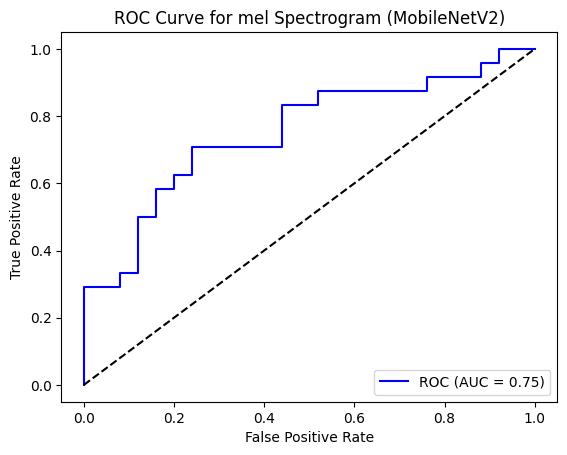

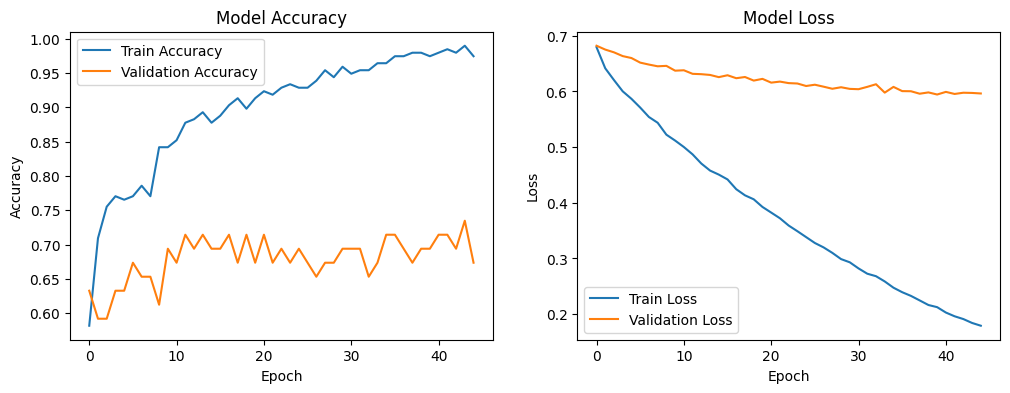


Complete Metrics Table:
    Accuracy  F1 Score  Precision    Recall  Specificity     Kappa   ROC AUC  \
0  69.387755  0.686542   0.709371  0.693878         0.84  0.383906  0.751667   

   Training Time (s)  Testing Time (s)  
0         105.785161          1.751847  


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram (MobileNetV2)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Save metrics to DataFrame for potential further analysis
    metrics_df = pd.DataFrame([metrics_dict])
    print("\nComplete Metrics Table:")
    print(metrics_df)

#Type 2 MFCC

Training model for spectrogram type: mfcc
Epoch 1/50
13/13 [==============================] - 18s 813ms/step - loss: 0.7044 - accuracy: 0.5153 - val_loss: 0.6931 - val_accuracy: 0.5102
Epoch 2/50
13/13 [==============================] - 7s 514ms/step - loss: 0.6936 - accuracy: 0.5153 - val_loss: 0.6937 - val_accuracy: 0.5102
Epoch 3/50
13/13 [==============================] - 7s 551ms/step - loss: 0.6941 - accuracy: 0.5153 - val_loss: 0.6937 - val_accuracy: 0.5102
Epoch 4/50
13/13 [==============================] - 7s 576ms/step - loss: 0.6946 - accuracy: 0.5153 - val_loss: 0.6931 - val_accuracy: 0.5102
Epoch 5/50
13/13 [==============================] - 8s 599ms/step - loss: 0.6932 - accuracy: 0.5153 - val_loss: 0.6930 - val_accuracy: 0.5102
Epoch 6/50
13/13 [==============================] - 7s 577ms/step - loss: 0.6933 - accuracy: 0.5153 - val_loss: 0.6930 - val_accuracy: 0.5102
Epoch 7/50
13/13 [==============================] - 7s 512ms/step - loss: 0.6929 - accuracy: 0.5153 - val

C:\Users\NUTAN SINGH\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


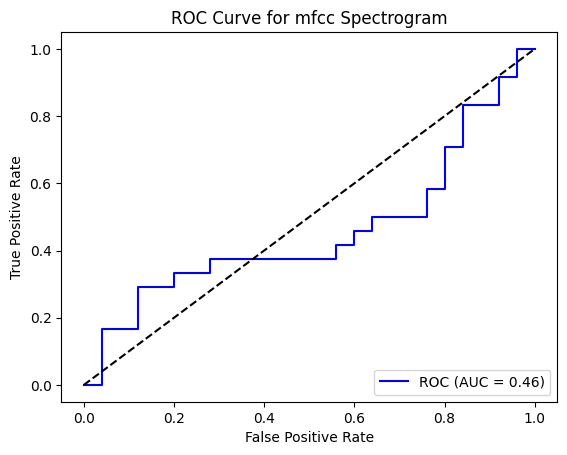


Performance Metrics for Spectrogram mfcc:
Accuracy: 51.02%
F1 Score: 0.34
Precision: 0.26
Recall: 0.51
Specificity: 1.00
Kappa: 0.00
ROC AUC: 0.46
Training Time: 147.98 seconds
Testing Time: 3.76 seconds


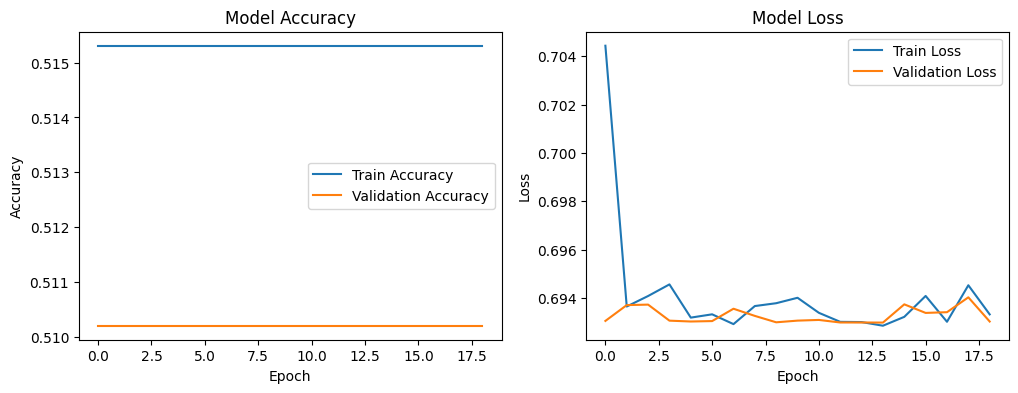

In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    
    # Shuffle and split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.2, stratify=labels, random_state=42)
    
    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=50, 
                        batch_size=16, 
                        verbose=1, 
                        callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display metrics
    print(f"\nPerformance Metrics for Spectrogram {spectrogram}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: mfcc
Epoch 1/50
13/13 [==============================] - 18s 1s/step - loss: 0.7061 - accuracy: 0.5153 - val_loss: 0.6975 - val_accuracy: 0.5102
Epoch 2/50
13/13 [==============================] - 17s 1s/step - loss: 0.6936 - accuracy: 0.5153 - val_loss: 0.6924 - val_accuracy: 0.5102
Epoch 3/50
13/13 [==============================] - 16s 1s/step - loss: 0.6943 - accuracy: 0.4643 - val_loss: 0.6909 - val_accuracy: 0.5918
Epoch 4/50
13/13 [==============================] - 16s 1s/step - loss: 0.6914 - accuracy: 0.4949 - val_loss: 0.6902 - val_accuracy: 0.5102
Epoch 5/50
13/13 [==============================] - 16s 1s/step - loss: 0.6913 - accuracy: 0.5153 - val_loss: 0.6896 - val_accuracy: 0.5102
Epoch 6/50
13/13 [==============================] - 16s 1s/step - loss: 0.6908 - accuracy: 0.5153 - val_loss: 0.6890 - val_accuracy: 0.5306
Epoch 7/50
13/13 [==============================] - 16s 1s/step - loss: 0.6903 - accuracy: 0.5306 - val_loss: 0.6888 -

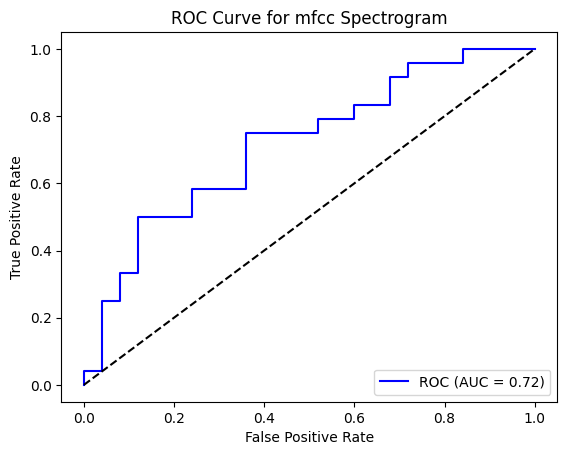

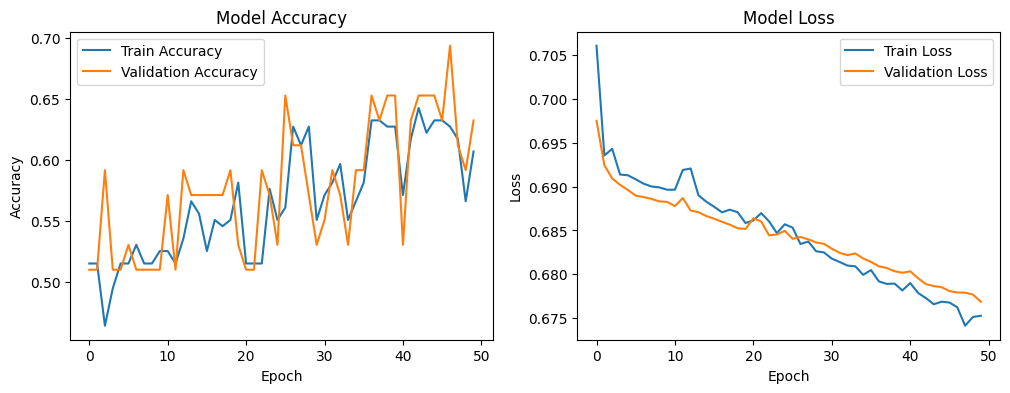

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary (similar to your fold_metrics structure)
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve (single curve instead of mean±std from k-fold)
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: mfcc
Epoch 1/50
13/13 [==============================] - 10s 289ms/step - loss: 0.7244 - accuracy: 0.4490 - val_loss: 0.7015 - val_accuracy: 0.5510
Epoch 2/50
13/13 [==============================] - 2s 165ms/step - loss: 0.6884 - accuracy: 0.5714 - val_loss: 0.7004 - val_accuracy: 0.5306
Epoch 3/50
13/13 [==============================] - 2s 162ms/step - loss: 0.6769 - accuracy: 0.5663 - val_loss: 0.7018 - val_accuracy: 0.4898
Epoch 4/50
13/13 [==============================] - 2s 185ms/step - loss: 0.6674 - accuracy: 0.5969 - val_loss: 0.6945 - val_accuracy: 0.5510
Epoch 5/50
13/13 [==============================] - 2s 185ms/step - loss: 0.6656 - accuracy: 0.5663 - val_loss: 0.6986 - val_accuracy: 0.4898
Epoch 6/50
13/13 [==============================] - 2s 187ms/step - loss: 0.6443 - accuracy: 0.6480 - val_loss: 0.6946 - val_accuracy: 0.5306
Epoch 7/50
13/13 [==============================] - 2s 190ms/step - loss: 0.6399 - accuracy: 0.6378 - val

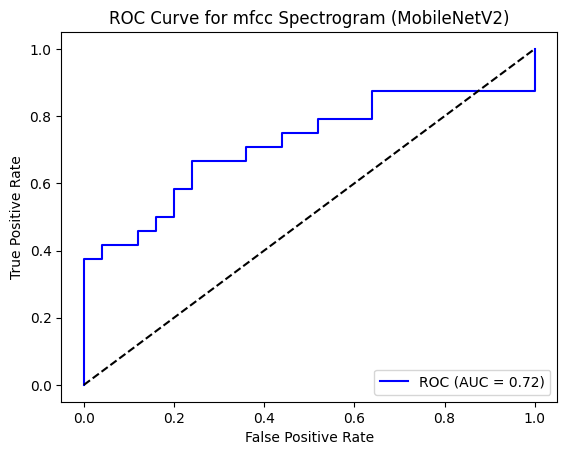

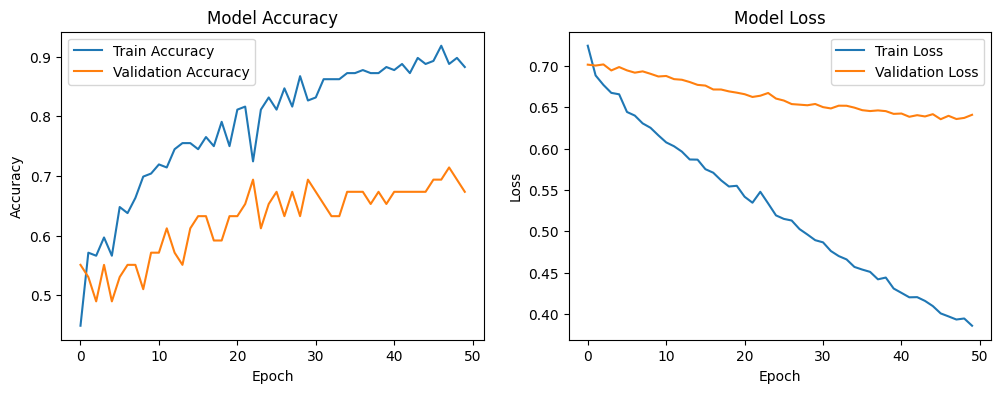


Complete Metrics Table:
    Accuracy  F1 Score  Precision    Recall  Specificity     Kappa   ROC AUC  \
0  67.346939  0.657716   0.705539  0.673469         0.88  0.341176  0.716667   

   Training Time (s)  Testing Time (s)  
0         124.585131          2.381537  


In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram (MobileNetV2)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Save metrics to DataFrame for potential further analysis
    metrics_df = pd.DataFrame([metrics_dict])
    print("\nComplete Metrics Table:")
    print(metrics_df)

In [ ]:
#Type 3 STFT

Training model for spectrogram type: stft
Epoch 1/50
13/13 [==============================] - 15s 801ms/step - loss: 0.7084 - accuracy: 0.5153 - val_loss: 0.7034 - val_accuracy: 0.5102
Epoch 2/50
13/13 [==============================] - 8s 604ms/step - loss: 0.6956 - accuracy: 0.5153 - val_loss: 0.6946 - val_accuracy: 0.5102
Epoch 3/50
13/13 [==============================] - 8s 619ms/step - loss: 0.6940 - accuracy: 0.5153 - val_loss: 0.6937 - val_accuracy: 0.5102
Epoch 4/50
13/13 [==============================] - 7s 537ms/step - loss: 0.6931 - accuracy: 0.5153 - val_loss: 0.6941 - val_accuracy: 0.5102
Epoch 5/50
13/13 [==============================] - 7s 553ms/step - loss: 0.6924 - accuracy: 0.5102 - val_loss: 0.6943 - val_accuracy: 0.5102
Epoch 6/50
13/13 [==============================] - 8s 599ms/step - loss: 0.6921 - accuracy: 0.5153 - val_loss: 0.6954 - val_accuracy: 0.5102
Epoch 7/50
13/13 [==============================] - 8s 608ms/step - loss: 0.6932 - accuracy: 0.5153 - val

C:\Users\NUTAN SINGH\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


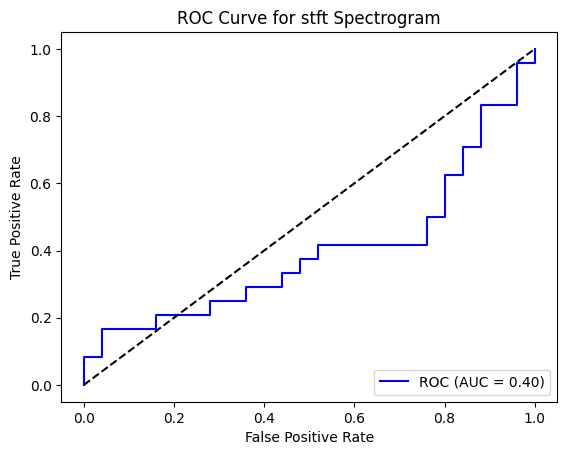


Performance Metrics for Spectrogram stft:
Accuracy: 51.02%
F1 Score: 0.34
Precision: 0.26
Recall: 0.51
Specificity: 1.00
Kappa: 0.00
ROC AUC: 0.40
Training Time: 68.08 seconds
Testing Time: 2.78 seconds


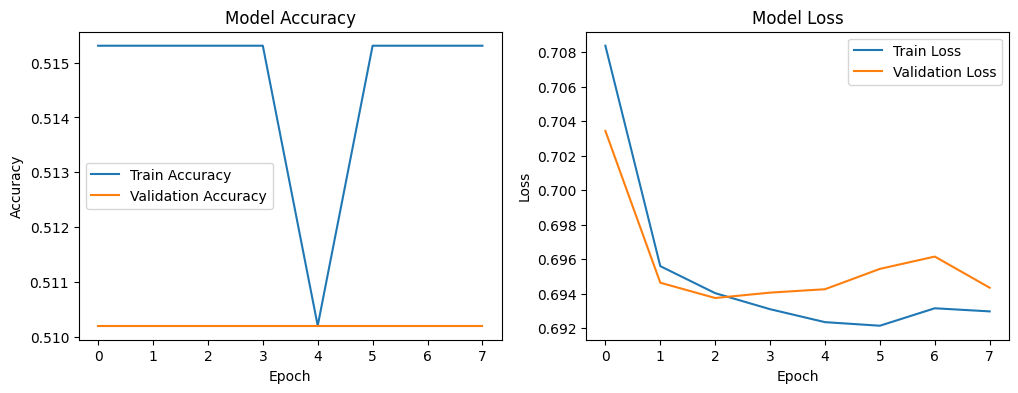

In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    
    # Shuffle and split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.2, stratify=labels, random_state=42)
    
    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=50, 
                        batch_size=16, 
                        verbose=1, 
                        callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display metrics
    print(f"\nPerformance Metrics for Spectrogram {spectrogram}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: stft
Epoch 1/50
13/13 [==============================] - 19s 1s/step - loss: 0.7289 - accuracy: 0.4847 - val_loss: 0.7017 - val_accuracy: 0.4898
Epoch 2/50
13/13 [==============================] - 17s 1s/step - loss: 0.7002 - accuracy: 0.4796 - val_loss: 0.6941 - val_accuracy: 0.4694
Epoch 3/50
13/13 [==============================] - 17s 1s/step - loss: 0.6934 - accuracy: 0.5204 - val_loss: 0.6927 - val_accuracy: 0.5102
Epoch 4/50
13/13 [==============================] - 17s 1s/step - loss: 0.6909 - accuracy: 0.5204 - val_loss: 0.6927 - val_accuracy: 0.5102
Epoch 5/50
13/13 [==============================] - 17s 1s/step - loss: 0.6900 - accuracy: 0.5255 - val_loss: 0.6928 - val_accuracy: 0.5510
Epoch 6/50
13/13 [==============================] - 17s 1s/step - loss: 0.6883 - accuracy: 0.5255 - val_loss: 0.6927 - val_accuracy: 0.5510
Epoch 7/50
13/13 [==============================] - 17s 1s/step - loss: 0.6876 - accuracy: 0.5306 - val_loss: 0.6924 -

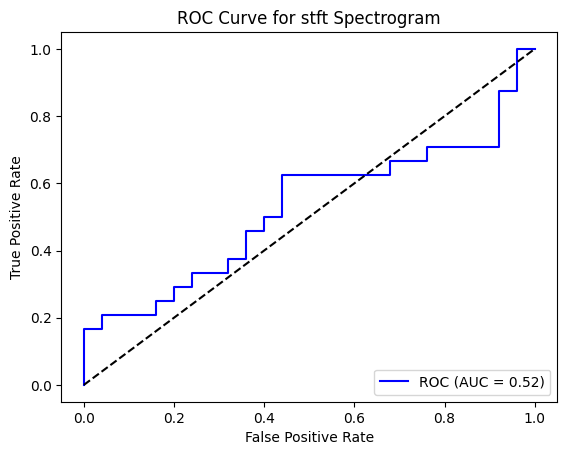

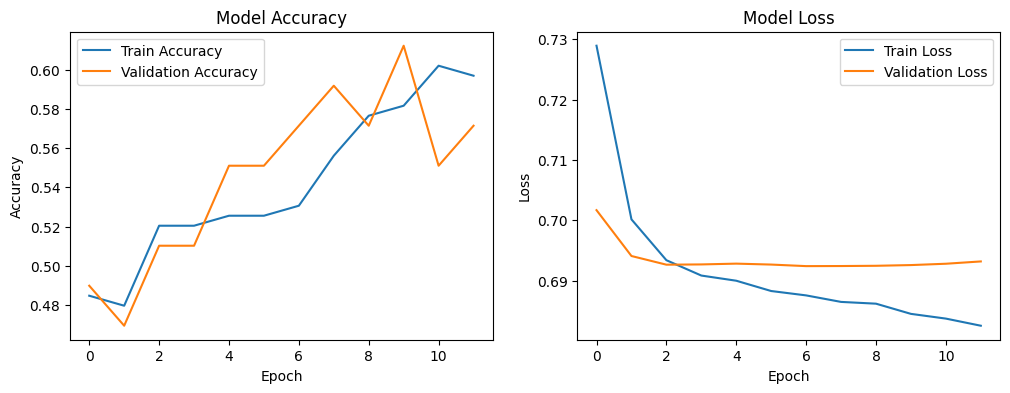

In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary (similar to your fold_metrics structure)
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve (single curve instead of mean±std from k-fold)
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: stft
Epoch 1/50
13/13 [==============================] - 10s 386ms/step - loss: 0.8162 - accuracy: 0.4898 - val_loss: 0.7634 - val_accuracy: 0.3878
Epoch 2/50
13/13 [==============================] - 3s 206ms/step - loss: 0.6937 - accuracy: 0.5408 - val_loss: 0.7500 - val_accuracy: 0.4286
Epoch 3/50
13/13 [==============================] - 3s 200ms/step - loss: 0.6656 - accuracy: 0.5969 - val_loss: 0.7276 - val_accuracy: 0.4898
Epoch 4/50
13/13 [==============================] - 3s 201ms/step - loss: 0.6382 - accuracy: 0.6684 - val_loss: 0.7177 - val_accuracy: 0.4898
Epoch 5/50
13/13 [==============================] - 3s 202ms/step - loss: 0.6164 - accuracy: 0.7143 - val_loss: 0.7127 - val_accuracy: 0.5102
Epoch 6/50
13/13 [==============================] - 3s 203ms/step - loss: 0.5968 - accuracy: 0.7653 - val_loss: 0.7078 - val_accuracy: 0.5102
Epoch 7/50
13/13 [==============================] - 3s 201ms/step - loss: 0.5805 - accuracy: 0.7602 - val

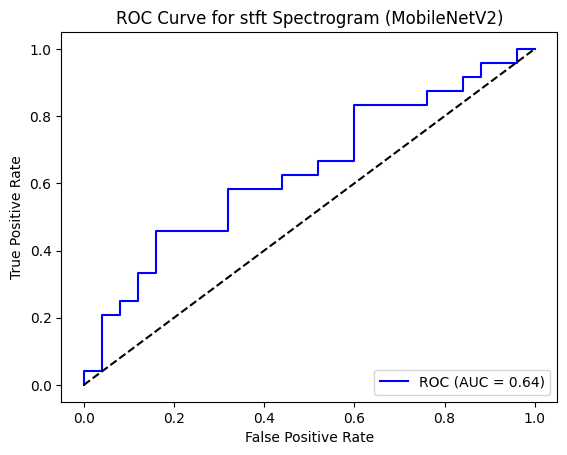

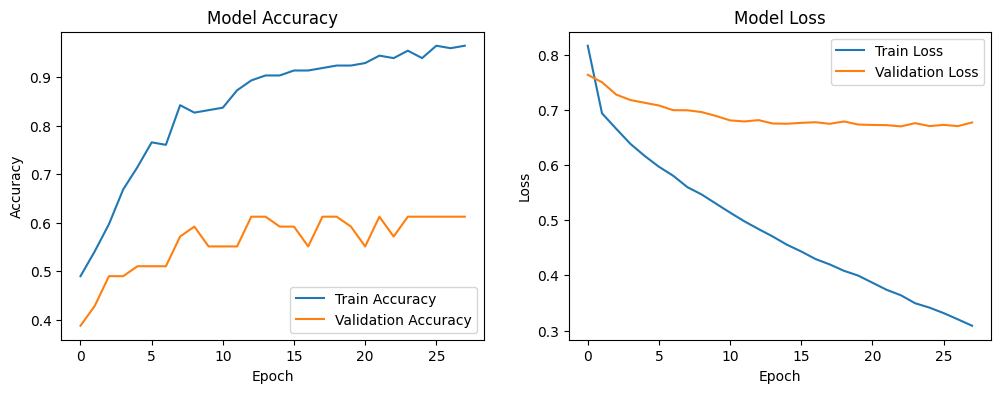


Complete Metrics Table:
    Accuracy  F1 Score  Precision    Recall  Specificity     Kappa   ROC AUC  \
0  57.142857  0.565992   0.572682  0.571429         0.68  0.138912  0.636667   

   Training Time (s)  Testing Time (s)  
0          77.510916          2.466511  


In [9]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram (MobileNetV2)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Save metrics to DataFrame for potential further analysis
    metrics_df = pd.DataFrame([metrics_dict])
    print("\nComplete Metrics Table:")
    print(metrics_df)

In [10]:
#Type 4 CQT

Training model for spectrogram type: cqt
Epoch 1/50
13/13 [==============================] - 18s 964ms/step - loss: 0.7051 - accuracy: 0.4847 - val_loss: 0.6958 - val_accuracy: 0.4898
Epoch 2/50
13/13 [==============================] - 9s 724ms/step - loss: 0.6936 - accuracy: 0.4847 - val_loss: 0.6943 - val_accuracy: 0.5102
Epoch 3/50
13/13 [==============================] - 9s 700ms/step - loss: 0.6928 - accuracy: 0.5153 - val_loss: 0.6944 - val_accuracy: 0.5102
Epoch 4/50
13/13 [==============================] - 8s 648ms/step - loss: 0.6921 - accuracy: 0.5153 - val_loss: 0.6948 - val_accuracy: 0.5102
Epoch 5/50
13/13 [==============================] - 9s 715ms/step - loss: 0.6917 - accuracy: 0.5153 - val_loss: 0.6946 - val_accuracy: 0.5102
Epoch 6/50
13/13 [==============================] - 8s 664ms/step - loss: 0.6922 - accuracy: 0.5102 - val_loss: 0.6944 - val_accuracy: 0.5102
Epoch 7/50
2/2 [==============================] - 3s 507ms/step


C:\Users\NUTAN SINGH\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


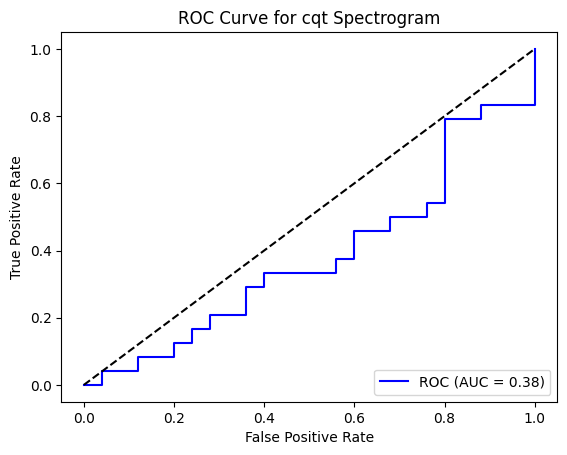


Performance Metrics for Spectrogram cqt:
Accuracy: 51.02%
F1 Score: 0.34
Precision: 0.26
Recall: 0.51
Specificity: 1.00
Kappa: 0.00
ROC AUC: 0.38
Training Time: 70.73 seconds
Testing Time: 2.91 seconds


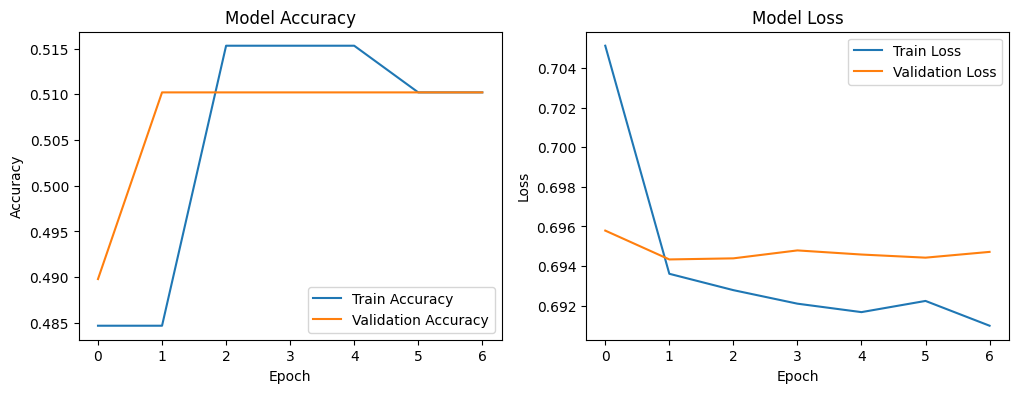

In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    
    # Shuffle and split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.2, stratify=labels, random_state=42)
    
    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=50, 
                        batch_size=16, 
                        verbose=1, 
                        callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display metrics
    print(f"\nPerformance Metrics for Spectrogram {spectrogram}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: cqt
Epoch 1/50
13/13 [==============================] - 19s 1s/step - loss: 0.6977 - accuracy: 0.4847 - val_loss: 0.6886 - val_accuracy: 0.6122
Epoch 2/50
13/13 [==============================] - 17s 1s/step - loss: 0.6905 - accuracy: 0.5357 - val_loss: 0.6897 - val_accuracy: 0.5306
Epoch 3/50
13/13 [==============================] - 17s 1s/step - loss: 0.6864 - accuracy: 0.5357 - val_loss: 0.6900 - val_accuracy: 0.4694
Epoch 4/50
13/13 [==============================] - 17s 1s/step - loss: 0.6855 - accuracy: 0.5306 - val_loss: 0.6910 - val_accuracy: 0.5306
Epoch 5/50
13/13 [==============================] - 17s 1s/step - loss: 0.6830 - accuracy: 0.5867 - val_loss: 0.6906 - val_accuracy: 0.5306
Epoch 6/50
2/2 [==============================] - 3s 1s/step

Performance Metrics for cqt Spectrogram:
Accuracy: 61.22%
F1 Score: 0.61
Precision: 0.61
Recall: 0.61
Specificity: 0.56
Kappa: 0.23
ROC AUC: 0.59
Training Time: 105.61 seconds
Testing Time: 3.46 se

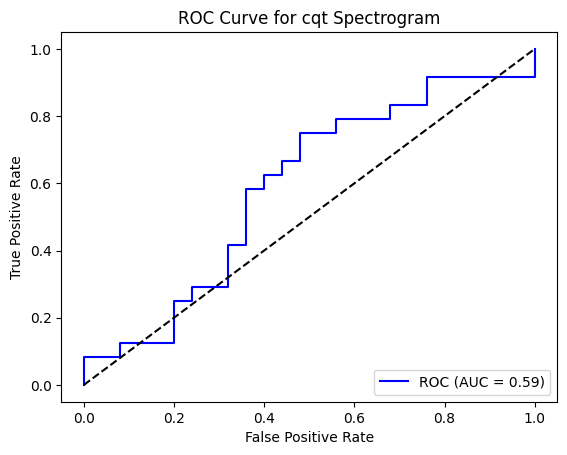

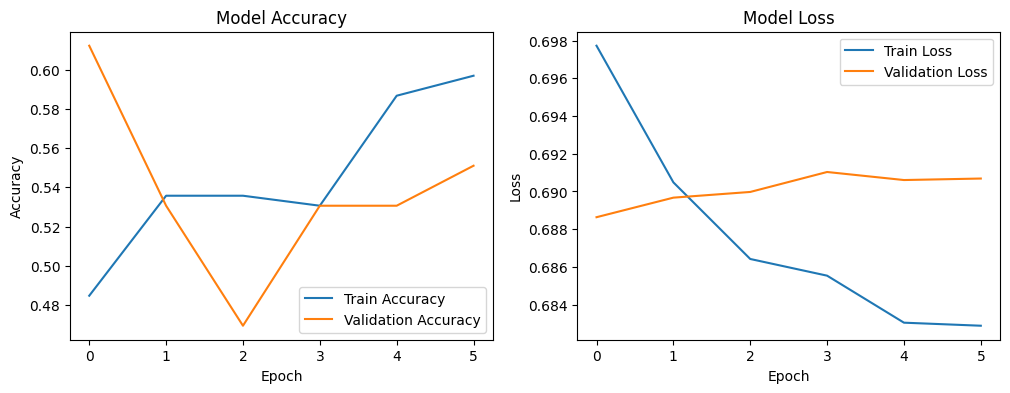

In [11]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary (similar to your fold_metrics structure)
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve (single curve instead of mean±std from k-fold)
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: cqt
Epoch 1/50
13/13 [==============================] - 12s 408ms/step - loss: 0.7429 - accuracy: 0.4796 - val_loss: 0.6992 - val_accuracy: 0.5918
Epoch 2/50
13/13 [==============================] - 3s 205ms/step - loss: 0.6855 - accuracy: 0.5561 - val_loss: 0.7025 - val_accuracy: 0.4898
Epoch 3/50
13/13 [==============================] - 3s 206ms/step - loss: 0.6656 - accuracy: 0.5867 - val_loss: 0.6900 - val_accuracy: 0.5714
Epoch 4/50
13/13 [==============================] - 2s 180ms/step - loss: 0.6380 - accuracy: 0.6633 - val_loss: 0.6830 - val_accuracy: 0.5510
Epoch 5/50
13/13 [==============================] - 2s 181ms/step - loss: 0.6133 - accuracy: 0.7143 - val_loss: 0.6793 - val_accuracy: 0.6122
Epoch 6/50
13/13 [==============================] - 2s 183ms/step - loss: 0.5952 - accuracy: 0.7449 - val_loss: 0.6745 - val_accuracy: 0.5714
Epoch 7/50
13/13 [==============================] - 2s 183ms/step - loss: 0.5761 - accuracy: 0.7857 - val_

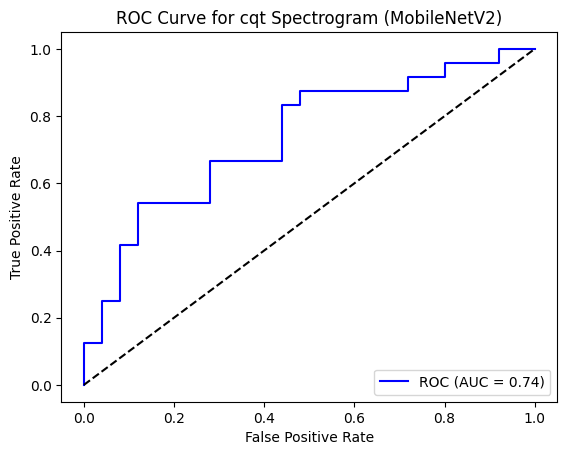

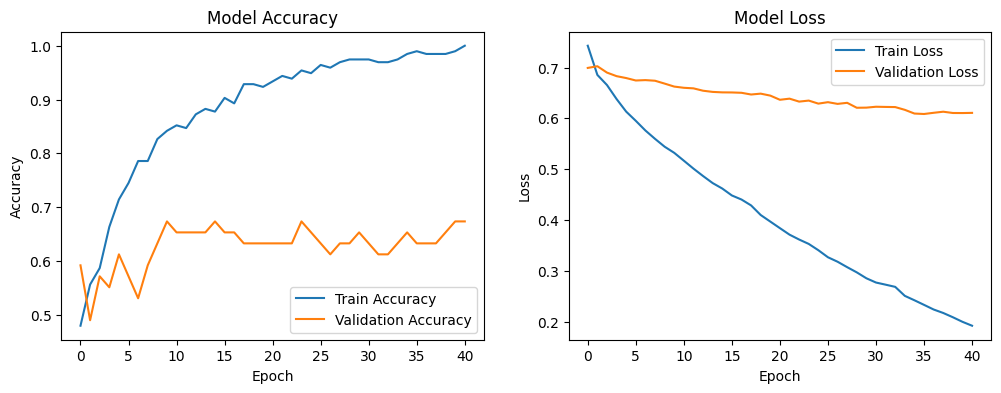


Complete Metrics Table:
    Accuracy  F1 Score  Precision    Recall  Specificity     Kappa   ROC AUC  \
0  63.265306  0.629561   0.635046  0.632653         0.72  0.262542  0.736667   

   Training Time (s)  Testing Time (s)  
0         113.108593          1.089948  


In [12]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram (MobileNetV2)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Save metrics to DataFrame for potential further analysis
    metrics_df = pd.DataFrame([metrics_dict])
    print("\nComplete Metrics Table:")
    print(metrics_df)

In [14]:
#Type 5 chroma

Training model for spectrogram type: chroma
Epoch 1/50
13/13 [==============================] - 13s 837ms/step - loss: 0.7058 - accuracy: 0.4847 - val_loss: 0.6945 - val_accuracy: 0.5102
Epoch 2/50
13/13 [==============================] - 10s 797ms/step - loss: 0.6936 - accuracy: 0.4694 - val_loss: 0.6931 - val_accuracy: 0.5102
Epoch 3/50
13/13 [==============================] - 9s 698ms/step - loss: 0.6916 - accuracy: 0.5153 - val_loss: 0.6941 - val_accuracy: 0.5102
Epoch 4/50
13/13 [==============================] - 9s 699ms/step - loss: 0.6915 - accuracy: 0.5306 - val_loss: 0.6934 - val_accuracy: 0.4694
Epoch 5/50
13/13 [==============================] - 10s 751ms/step - loss: 0.6902 - accuracy: 0.5765 - val_loss: 0.6939 - val_accuracy: 0.5306
Epoch 6/50
13/13 [==============================] - 10s 758ms/step - loss: 0.6890 - accuracy: 0.5153 - val_loss: 0.6942 - val_accuracy: 0.5102
Epoch 7/50
2/2 [==============================] - 4s 628ms/step


C:\Users\NUTAN SINGH\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


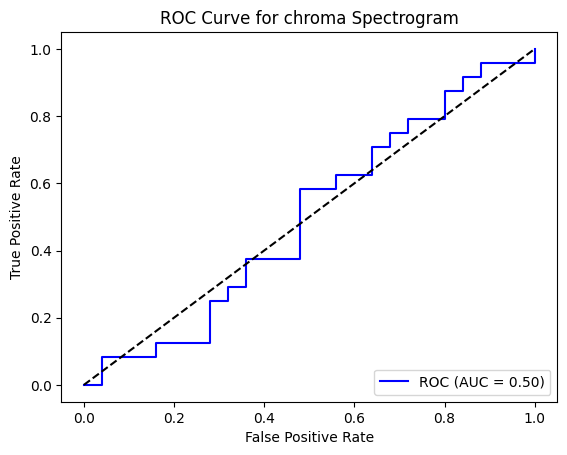


Performance Metrics for Spectrogram chroma:
Accuracy: 51.02%
F1 Score: 0.34
Precision: 0.26
Recall: 0.51
Specificity: 1.00
Kappa: 0.00
ROC AUC: 0.50
Training Time: 69.26 seconds
Testing Time: 3.94 seconds


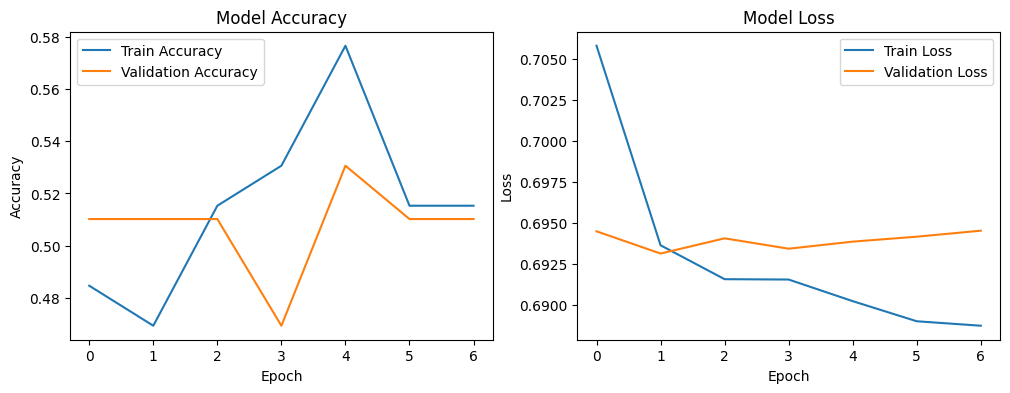

In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    
    # Shuffle and split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.2, stratify=labels, random_state=42)
    
    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=50, 
                        batch_size=16, 
                        verbose=1, 
                        callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display metrics
    print(f"\nPerformance Metrics for Spectrogram {spectrogram}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: chroma
Epoch 1/50
13/13 [==============================] - 27s 2s/step - loss: 0.7059 - accuracy: 0.5153 - val_loss: 0.6921 - val_accuracy: 0.5102
Epoch 2/50
13/13 [==============================] - 24s 2s/step - loss: 0.6976 - accuracy: 0.5153 - val_loss: 0.6881 - val_accuracy: 0.5102
Epoch 3/50
13/13 [==============================] - 24s 2s/step - loss: 0.6943 - accuracy: 0.5153 - val_loss: 0.6872 - val_accuracy: 0.5102
Epoch 4/50
13/13 [==============================] - 25s 2s/step - loss: 0.6929 - accuracy: 0.5153 - val_loss: 0.6867 - val_accuracy: 0.5102
Epoch 5/50
13/13 [==============================] - 25s 2s/step - loss: 0.6907 - accuracy: 0.5153 - val_loss: 0.6861 - val_accuracy: 0.5918
Epoch 6/50
13/13 [==============================] - 25s 2s/step - loss: 0.6911 - accuracy: 0.5153 - val_loss: 0.6860 - val_accuracy: 0.5306
Epoch 7/50
13/13 [==============================] - 24s 2s/step - loss: 0.6896 - accuracy: 0.5255 - val_loss: 0.6857

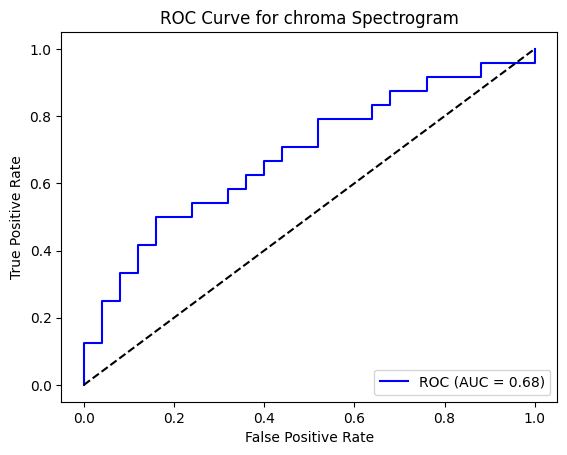

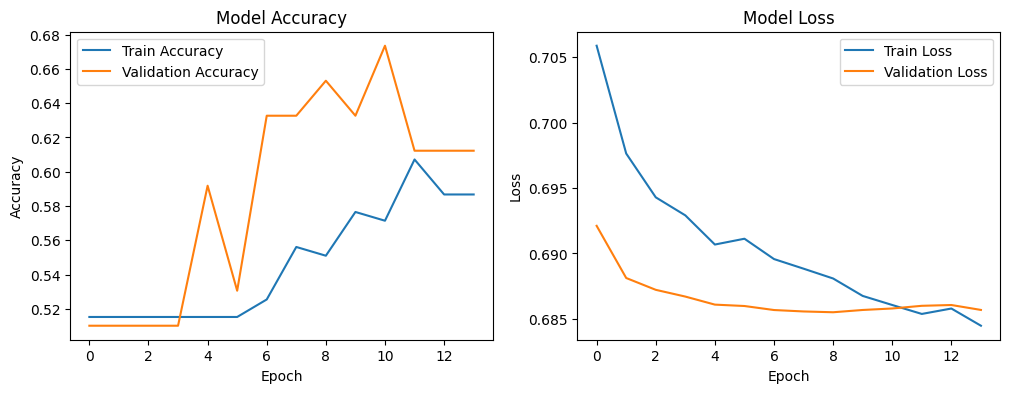

In [14]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary (similar to your fold_metrics structure)
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve (single curve instead of mean±std from k-fold)
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: chroma
Epoch 1/50
13/13 [==============================] - 14s 489ms/step - loss: 0.7156 - accuracy: 0.5000 - val_loss: 0.6893 - val_accuracy: 0.5306
Epoch 2/50
13/13 [==============================] - 3s 252ms/step - loss: 0.6877 - accuracy: 0.5714 - val_loss: 0.6822 - val_accuracy: 0.5714
Epoch 3/50
13/13 [==============================] - 3s 240ms/step - loss: 0.6709 - accuracy: 0.6173 - val_loss: 0.6827 - val_accuracy: 0.5306
Epoch 4/50
13/13 [==============================] - 3s 246ms/step - loss: 0.6595 - accuracy: 0.6071 - val_loss: 0.6834 - val_accuracy: 0.5306
Epoch 5/50
13/13 [==============================] - 3s 251ms/step - loss: 0.6479 - accuracy: 0.6582 - val_loss: 0.6831 - val_accuracy: 0.5306
Epoch 6/50
13/13 [==============================] - 3s 250ms/step - loss: 0.6404 - accuracy: 0.6735 - val_loss: 0.6823 - val_accuracy: 0.6122
Epoch 7/50
2/2 [==============================] - 3s 148ms/step

Performance Metrics for chroma Spectro

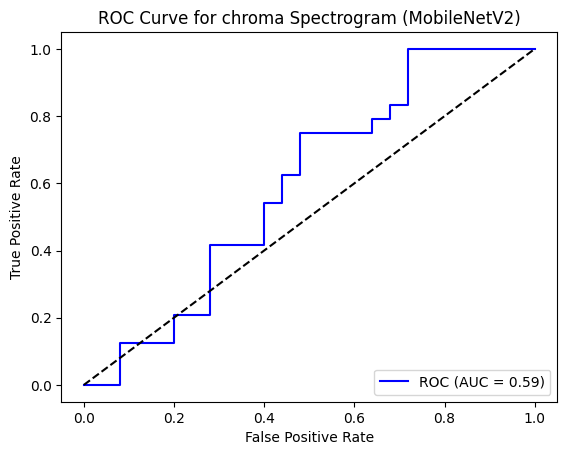

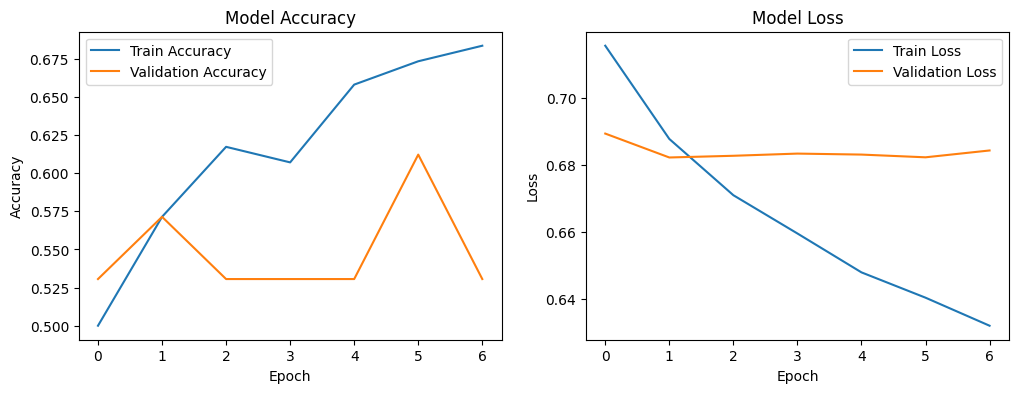


Complete Metrics Table:
    Accuracy  F1 Score  Precision    Recall  Specificity     Kappa   ROC AUC  \
0  57.142857  0.571429   0.571905  0.571429         0.56  0.143214  0.593333   

   Training Time (s)  Testing Time (s)  
0          33.081925           3.09489  


In [15]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram (MobileNetV2)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Save metrics to DataFrame for potential further analysis
    metrics_df = pd.DataFrame([metrics_dict])
    print("\nComplete Metrics Table:")
    print(metrics_df)